In [21]:
#Importing libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Embedding, Dropout
from sklearn import preprocessing
import datetime as dt
from pandas.tseries.offsets import DateOffset

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#Reading data
url = "https://hub.mph.in.gov/dataset/bd08cdd3-9ab1-4d70-b933-41f9ef7b809d/resource/afaa225d-ac4e-4e80-9190-f6800c366b58/download/covid_report_county_date.xlsx?raw=true"
cases_data = pd.read_excel(url)

population_data = pd.read_csv(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/population density of indiana county.csv")

#Data preprocessing
population_data["County"] = population_data["County"].str.upper()
population_data["County"] = population_data["County"].str.replace('.', '')
population_data["County"] = population_data["County"].str.replace(' ', '')

cases_data["COUNTY_NAME"] = cases_data["COUNTY_NAME"].str.upper()
cases_data["COUNTY_NAME"] = cases_data["COUNTY_NAME"].str.replace('.', '')
cases_data["COUNTY_NAME"] = cases_data["COUNTY_NAME"].str.replace(' ','')

data = pd.merge(cases_data, population_data, how = 'inner', left_on = 'COUNTY_NAME', right_on = 'County')
data = data[["COUNTY_NAME", "DATE", "COVID_COUNT",  "COVID_DEATHS", "COVID_TESTS", "Population", "Area", "Population Density"]]

data

,COUNTY_NAME,DATE,COVID_COUNT,COVID_DEATHS,COVID_TESTS,Population,Area,Population Density
0,ADAMS,2020-02-26,0,0,0,34387.0,339,101.436578
1,ADAMS,2020-02-27,0,0,0,34387.0,339,101.436578
2,ADAMS,2020-02-28,0,0,0,34387.0,339,101.436578
3,ADAMS,2020-02-29,0,0,0,34387.0,339,101.436578
4,ADAMS,2020-03-02,0,0,0,34387.0,339,101.436578
...,...,...,...,...,...,...,...,...
29159,WHITLEY,2021-01-04,15,0,76,33292.0,336,99.083333
29160,WHITLEY,2021-01-05,37,1,81,33292.0,336,99.083333
29161,WHITLEY,2021-01-06,36,0,66,33292.0,336,99.083333
29162,WHITLEY,2021-01-07,33,0,46,33292.0,336,99.083333


In [23]:
data.describe()

,COVID_COUNT,COVID_DEATHS,COVID_TESTS,Population,Area,Population Density
count,29164.000000,29164.000000,29164.000000,29164.000000,29164.000000,29164.000000
mean,19.152380,0.294713,93.914209,70436.967391,389.434783,177.640432
std,55.600985,0.928651,216.345047,116124.470119,95.497859,280.271532
min,0.000000,0.000000,0.000000,6128.000000,86.000000,21.807882
25%,0.000000,0.000000,9.000000,21494.500000,360.250000,57.580223
50%,3.000000,0.000000,30.000000,33844.000000,396.500000,82.635162
75%,15.000000,0.000000,81.000000,69188.250000,444.250000,169.554527
max,1150.000000,16.000000,3704.000000,903393.000000,657.000000,2281.295455


In [24]:
county_name = data["COUNTY_NAME"].unique()
print(county_name)
print(len(county_name))

['ADAMS' 'ALLEN' 'BARTHOLOMEW' 'BENTON' 'BLACKFORD' 'BOONE' 'BROWN'
 'CARROLL' 'CASS' 'CLARK' 'CLAY' 'CLINTON' 'CRAWFORD' 'DAVIESS' 'DEARBORN'
 'DECATUR' 'DEKALB' 'DELAWARE' 'DUBOIS' 'ELKHART' 'FAYETTE' 'FLOYD'
 'FOUNTAIN' 'FRANKLIN' 'FULTON' 'GIBSON' 'GRANT' 'GREENE' 'HAMILTON'
 'HANCOCK' 'HARRISON' 'HENDRICKS' 'HENRY' 'HOWARD' 'HUNTINGTON' 'JACKSON'
 'JASPER' 'JAY' 'JEFFERSON' 'JENNINGS' 'JOHNSON' 'KNOX' 'KOSCIUSKO'
 'LAGRANGE' 'LAKE' 'LAPORTE' 'LAWRENCE' 'MADISON' 'MARION' 'MARSHALL'
 'MARTIN' 'MIAMI' 'MONROE' 'MONTGOMERY' 'MORGAN' 'NEWTON' 'NOBLE' 'OHIO'
 'ORANGE' 'OWEN' 'PARKE' 'PERRY' 'PIKE' 'PORTER' 'POSEY' 'PULASKI'
 'PUTNAM' 'RANDOLPH' 'RIPLEY' 'RUSH' 'STJOSEPH' 'SCOTT' 'SHELBY' 'SPENCER'
 'STARKE' 'STEUBEN' 'SULLIVAN' 'SWITZERLAND' 'TIPPECANOE' 'TIPTON' 'UNION'
 'VANDERBURGH' 'VERMILLION' 'VIGO' 'WABASH' 'WARREN' 'WARRICK'
 'WASHINGTON' 'WAYNE' 'WELLS' 'WHITE' 'WHITLEY']
92


In [25]:
print('Length of the sample: ', len(data))

Length of the sample:  29164


In [26]:
# Model Parameters
time_steps = 21  # No. of historical data to be used for forecasting
BATCH_SIZE = 1024  # No. of observations to be used at a time for training
NO_OF_DAYS_TO_PREDICT = 5 # No. of days to forecasted

In [27]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [28]:
#Scaling the data
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(data[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TESTS', 'Population', 'Area', 'Population Density']])

data["COVID_COUNT"] = scaled_data[:, 0]
data["COVID_DEATHS"] = scaled_data[:, 1]
data["COVID_TESTS"] = scaled_data[:, 2]
data["Population"] = scaled_data[:, 3]
data["Area"] = scaled_data[:, 4]
data["Population Density"] = scaled_data[:, 5]

data

,COUNTY_NAME,DATE,COVID_COUNT,COVID_DEATHS,COVID_TESTS,Population,Area,Population Density
0,ADAMS,2020-02-26,-0.344467,-0.317361,-0.434102,-0.310448,-0.528134,-0.271898
1,ADAMS,2020-02-27,-0.344467,-0.317361,-0.434102,-0.310448,-0.528134,-0.271898
2,ADAMS,2020-02-28,-0.344467,-0.317361,-0.434102,-0.310448,-0.528134,-0.271898
3,ADAMS,2020-02-29,-0.344467,-0.317361,-0.434102,-0.310448,-0.528134,-0.271898
4,ADAMS,2020-03-02,-0.344467,-0.317361,-0.434102,-0.310448,-0.528134,-0.271898
...,...,...,...,...,...,...,...,...
29159,WHITLEY,2021-01-04,-0.074683,-0.317361,-0.082805,-0.319877,-0.559549,-0.280294
29160,WHITLEY,2021-01-05,0.321000,0.759488,-0.059694,-0.319877,-0.559549,-0.280294
29161,WHITLEY,2021-01-06,0.303015,-0.317361,-0.129029,-0.319877,-0.559549,-0.280294
29162,WHITLEY,2021-01-07,0.249058,-0.317361,-0.221475,-0.319877,-0.559549,-0.280294


In [29]:
# reshapes to [samples, time_steps, n_features]
X_train, y_train = [], []

for county in county_name:
  filtered_data = data.loc[data["COUNTY_NAME"] == county]
  train_size = len(filtered_data)
  filtered_train = filtered_data.iloc[0:train_size]
  
  filtered_X_train, filtered_y_train = create_dataset(filtered_train[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TESTS', 'Population', 'Area', 'Population Density']], 
                                                      filtered_train[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TESTS']], time_steps)

  if(len(X_train) == 0):
    X_train, y_train = filtered_X_train, filtered_y_train
  else:
    X_train = np.vstack((X_train, filtered_X_train))
    y_train = np.vstack((y_train, filtered_y_train))

print(X_train.shape, y_train.shape)

(27232, 21, 6) (27232, 3)


In [30]:
# Loading model
model = keras.models.load_model(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/checkpoint.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 21, 1024)          4222976   
_________________________________________________________________
dropout_8 (Dropout)          (None, 21, 1024)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 21, 512)           3147776   
_________________________________________________________________
dropout_9 (Dropout)          (None, 21, 512)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 256)           787456    
_________________________________________________________________
dropout_10 (Dropout)         (None, 21, 256)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)               

In [ ]:
#Defining Model
# model = Sequential()
# model.add(LSTM(BATCH_SIZE, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.1))
# model.add(LSTM(512, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(256, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.1))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(3))

# model.summary()

# model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop', metrics = ['mse', 'accuracy'])

In [ ]:
#1500 epochs for training model

history = model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = BATCH_SIZE
)

Epoch 1/50
27/27 [==============================] - 17s 307ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - accuracy: 0.9338
Epoch 2/50
27/27 [==============================] - 8s 311ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - accuracy: 0.9355
Epoch 3/50
27/27 [==============================] - 8s 314ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - accuracy: 0.9254
Epoch 4/50
27/27 [==============================] - 9s 320ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - accuracy: 0.9234
Epoch 5/50
27/27 [==============================] - 9s 326ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - accuracy: 0.9335
Epoch 6/50
27/27 [==============================] - 9s 336ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - accuracy: 0.9363
Epoch 7/50
27/27 [==============================] - 9s 344ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - accuracy: 0.9364
Epoch 8/50
27/27 [==============================] - 9s 343ms/step - loss: 0.0032 - mean_squared_

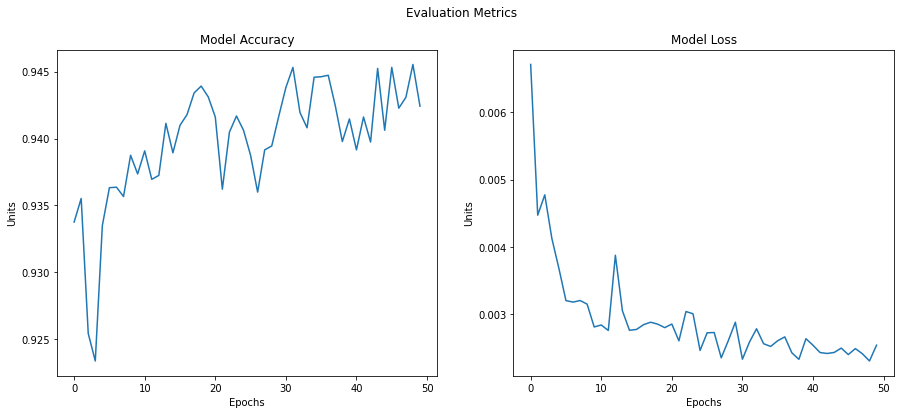

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Evaluation Metrics')
fig.set_size_inches(15, 6)

ax1.plot(history.history['accuracy'])
ax1.title.set_text('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Units')

ax2.plot(history.history['loss'])
ax2.title.set_text('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Units')

plt.show()

In [ ]:
checkpoint_path = f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/checkpoint.h5"
model.save(checkpoint_path)

In [32]:
forecasted_data = pd.DataFrame()

for county in county_name:
  demo_data = data[data['COUNTY_NAME'] == county]
  demo_data = demo_data[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TESTS', 'Population', 'Area', 'Population Density']]
  demo_data = demo_data.tail(time_steps + 1)

  for day in range(NO_OF_DAYS_TO_PREDICT):
    demo_X_test, demo_y_test = create_dataset(demo_data[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TESTS', 'Population', 'Area', 'Population Density']].tail(time_steps + 1), 
                                                        demo_data[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TESTS']].tail(time_steps + 1), time_steps)
    
    predictions = np.concatenate((model.predict(demo_X_test), np.zeros((1, 3))), axis = 1)

    predictions[0,3] = np.array(demo_data['Population'])[0]
    predictions[0,4] = np.array(demo_data['Area'])[0]
    predictions[0,5] = np.array(demo_data['Population Density'])[0]

    demo_data = pd.DataFrame(np.concatenate((demo_data, predictions), axis = 0))
    demo_data.columns = ['COVID_COUNT', 'COVID_DEATHS', 'COVID_TESTS', 'Population', 'Area', 'Population Density']

  transformed_demo_data = np.intc(scaler.inverse_transform(demo_data))
  demo_data['COVID_COUNT'] = np.ceil(np.abs(transformed_demo_data[:, 0]))
  demo_data['COVID_DEATHS'] = np.ceil(np.abs(transformed_demo_data[:, 1]))
  demo_data['COVID_TESTS'] = np.ceil(np.abs(transformed_demo_data[:, 2]))
  demo_data['Population'] = transformed_demo_data[:, 3]
  demo_data['Area'] = transformed_demo_data[:, 4]
  demo_data['Population Density'] = transformed_demo_data[:, 5]

  demo_data = demo_data[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TESTS']]
  date_data = data[['DATE']]
  date_data = date_data.tail(time_steps + 6)

  date_data['DATE'] = pd.to_datetime(date_data['DATE']) + DateOffset(5)

  fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
  fig.suptitle('COVID FORECASTING for ' + county + ' County')
  fig.set_size_inches(10, 26)
  plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
  plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
  plt.setp(ax3.xaxis.get_majorticklabels(), rotation=90)

  ax1.plot(date_data, demo_data['COVID_COUNT'], linestyle='-', marker='o', color = 'red', label = 'COVID CASES')
  ax1.grid(True)
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Case Count')
  ax1.legend()

  ax2.plot(date_data, demo_data['COVID_DEATHS'], linestyle='-', marker='o', color = 'blue', label = 'COVID DEATHS')
  ax2.grid(True)
  ax2.set_xlabel('Date')
  ax2.set_ylabel('Death Count')
  ax2.legend()

  ax3.plot(date_data, demo_data['COVID_TESTS'], linestyle='-', marker='o', color = 'green', label = 'COVID TESTS')
  ax3.grid(True)
  ax3.set_xlabel('Date')
  ax3.set_ylabel('Test Count')
  ax3.legend()
  # plt.show()

  fig.savefig(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/output_images/"+county+".png", bbox_inches='tight')
  plt.close()

  demo_data['COUNTY_NAME'] =  county
  forecasted_data = pd.concat([forecasted_data, pd.DataFrame(demo_data.iloc[[time_steps + 1]])])

In [33]:
forecasted_data

,COVID_COUNT,COVID_DEATHS,COVID_TESTS,COUNTY_NAME
22,28.0,0.0,14.0,ADAMS
22,271.0,0.0,5.0,ALLEN
22,72.0,0.0,8.0,BARTHOLOMEW
22,4.0,0.0,15.0,BENTON
22,9.0,0.0,14.0,BLACKFORD
...,...,...,...,...
22,21.0,0.0,5.0,WASHINGTON
22,49.0,1.0,4.0,WAYNE
22,19.0,0.0,14.0,WELLS
22,25.0,0.0,9.0,WHITE


In [34]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

fips_code = pd.read_excel(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/indiana_county_fips.xlsx")
county_stats = pd.merge(fips_code, forecasted_data, how = 'inner', left_on = 'COUNTY_NAME', right_on = 'COUNTY_NAME')

county_stats = county_stats[["COUNTY_NAME", "STATE", "FIPS_CODE", "COVID_COUNT", "COVID_DEATHS", "COVID_TESTS"]]
county_stats.head(5)

,COUNTY_NAME,STATE,FIPS_CODE,COVID_COUNT,COVID_DEATHS,COVID_TESTS
0,ADAMS,IN,18001,28.0,0.0,14.0
1,ALLEN,IN,18003,271.0,0.0,5.0
2,BARTHOLOMEW,IN,18005,72.0,0.0,8.0
3,BENTON,IN,18007,4.0,0.0,15.0
4,BLACKFORD,IN,18009,9.0,0.0,14.0


In [38]:
import plotly.express as px

fig = px.choropleth_mapbox(county_stats, geojson=counties, locations='FIPS_CODE',
                           color='COVID_COUNT',
                           mapbox_style="carto-positron",
                           zoom=6, center = {"lat": 39.8362, "lon": -86.1752},
                           opacity=0.5,
                           labels={'COVID_COUNT':'FORECASTED COVID COUNT'},
                           hover_name = "COUNTY_NAME"
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.update_traces(customdata = county_stats, hovertemplate='<b>%{customdata[0]}</b> <br>'+
                  'Forecasted COVID Count: %{customdata[3]}<extra></extra>'
                                )
fig.update_layout(hovermode="x")

# fig.show()

fig.write_html(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/Forecasted_COVID_COUNT.html")

In [39]:
fig = px.choropleth_mapbox(county_stats, geojson=counties, locations='FIPS_CODE', 
                           color='COVID_DEATHS',
                           mapbox_style="carto-positron",
                           zoom=6, center = {"lat": 39.8362, "lon": -86.1752},
                           opacity=0.5,
                           labels={'COVID_DEATHS':'FORECASTED COVID DEATHS'},
                           hover_name = "COUNTY_NAME"
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.update_traces(customdata = county_stats, hovertemplate='<b>%{customdata[0]}</b> <br>'+
                  'Forecasted COVID Deaths: %{customdata[4]}<extra></extra>'
                                )
fig.update_layout(hovermode="x")

# fig.show()

fig.write_html(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/Forecasted_COVID_DEATHS.html")

In [40]:
fig = px.choropleth_mapbox(county_stats, geojson=counties, locations='FIPS_CODE', 
                           color='COVID_TESTS',
                           mapbox_style="carto-positron",
                           zoom=6, center = {"lat": 39.8362, "lon": -86.1752},
                           opacity=0.5,
                           labels={'COVID_TESTS':'FORECASTED COVID TEST'},
                           hover_name = "COUNTY_NAME"
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.update_traces(customdata = county_stats, hovertemplate='<b>%{customdata[0]}</b> <br>'+
                  'Forecasted COVID Test: %{customdata[5]}<extra></extra>'
                                )
fig.update_layout(hovermode="x")

# fig.show()

fig.write_html(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/Forecasted_COVID_TEST.html")